# NOAA 20CR Data - Code to analyze Volatility of Daily Max Temperature 

## 1: Import libraries

In [1]:
import netCDF4 as nc
import numpy as np
import h5py
import os
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import pymannkendall as mk
import scipy 
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from scipy import stats
import datetime as dt
import calendar

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## 2: Import and pre-process dataset

In [ ]:
## First, download the dataset from https://psl.noaa.gov/data/gridded/data.20thC_ReanV3.html
## The data is downloaded as .netcdf files
## Change the directory as shown below and proceed with the codes below

In [2]:
os.chdir('.../Volatility/NOAA 20CR/')
files = sorted(glob.glob('*.nc'))
tmax = np.empty([43, 87, 1])
years= np.arange(1950, 2015)

for i in range(len(files)):
    
    filename = files[i]
    ds = nc.Dataset(filename)
    data = ds['tmax'][:]
    data = np.transpose(data, (1,2,0))
    data = data[56:99,333:420,:]
    
    year = years[i]
    if calendar.isleap(year):
        nd= 366
    else:
        nd= 365
        
    step= int(np.floor(data.shape[2]/nd))    
    
    d = np.empty([data.shape[0], data.shape[1], nd])
    

    loc=0
    for j in np.arange(0,data.shape[2]-step,step):
        
        d[:,:,loc] = np.amax(data[:,:,j:(j+step)], axis= 2) 
        loc= loc+1
    
    tmax = np.concatenate((tmax, d), axis=2)

In [3]:
# Convert from K to C
tmax = tmax - 273.15

In [4]:
# Remove the first slice (empty slice)
tmax = tmax[:,:,1:]

In [5]:
# Remove Nan values
tmax[tmax==(9999-273.15)]= np.nan

In [6]:
# The 3d array to be used as the input for analysis. (lat*lon*time)
tmax.shape

(43, 87, 23741)

## 3: Compute volatility

In [7]:
date = pd.date_range(start='01/01/1950', end='12/31/2014')

volatility_95p = np.empty([43, 87, 65])
volatility_95p[:] = np.nan

for lat in range(d.shape[0]):
    for lon in range(d.shape[1]):
        
        v = pd.DataFrame(columns= ['date', 'day', 'month', 'year', 'volatility'], index= list(range(len(date))))
        v['date'] = date
        v['day'] = v.date.dt.day
        v['month'] = v.date.dt.month
        v['year'] = v.date.dt.year
        
        x = tmax[lat,lon,:]
        v['volatility'][1:] = abs(x[1:] - x[:-1])
        v['volatility'] = v['volatility'].astype(float)
        v= v.drop(v[(v['day'] == 31) & (v['month']== 12)].index)
        v= v.drop(v[(v['day'] == 1) & (v['month']== 1)].index)
        
        for y in range(len(years)):
            dummy= v[v['year']== years[y]]
            volatility_95p[lat,lon,y] = np.nanpercentile(dummy['volatility'],95) 

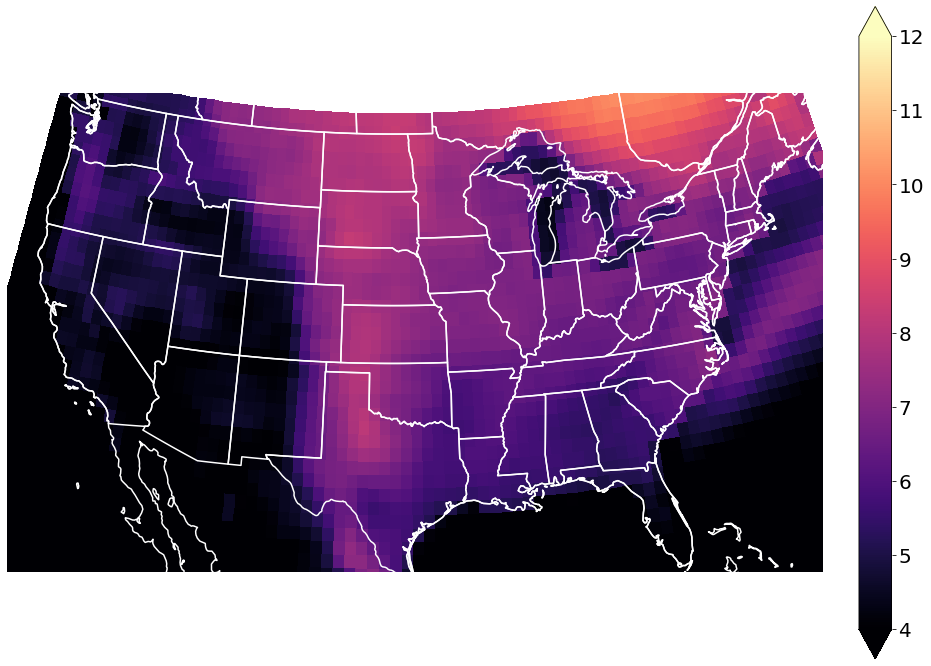

In [6]:
volatility_95p = np.load('.../Results/NOAA20CR_volatility_95p.csv.npy')

from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'white', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'white', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-125.8593,-64.6874,0.7)
gridlats= np.arange(20,50.1753,0.7)
plot = plt.pcolormesh(gridlons, gridlats, np.flipud(np.nanmean(volatility_95p, axis= 2)), 
                      transform=crs.PlateCarree(), cmap= 'magma', vmin= 4, vmax= 12)

font = {'family':'serif','weight':'bold', 'size': 16}
#plt.title('1950-2014 Mean Volatility [$\circ$C] _ NOAA 20CR', fontdict= font)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/NOAA20CR_Climatology_Volatility95p_1950_2015.jpeg'
            ,dpi=600)

plt.show()

## 4: Analysis of trends in volatility

In [11]:
trend_pv = np.empty([43, 87])
trend_pv[:] = np.nan

trend_slope = np.empty([43, 87])
trend_slope[:] = np.nan

for lat in range(trend_pv.shape[0]):
    for lon in range(trend_pv.shape[1]):
         
            x = volatility_95p[lat,lon,:]
            if (~np.isnan(x[0])):
                result = mk.original_test(x)
                trend_pv[lat,lon] = result.p
                trend_slope[lat,lon] = result.slope    

In [42]:
x = np.sort(trend_pv.flatten())
y = (np.arange(1, len(x)+1)/len(x))*0.05
alpha_new = max(x[x<y])
alpha_new

0.033969805841611356

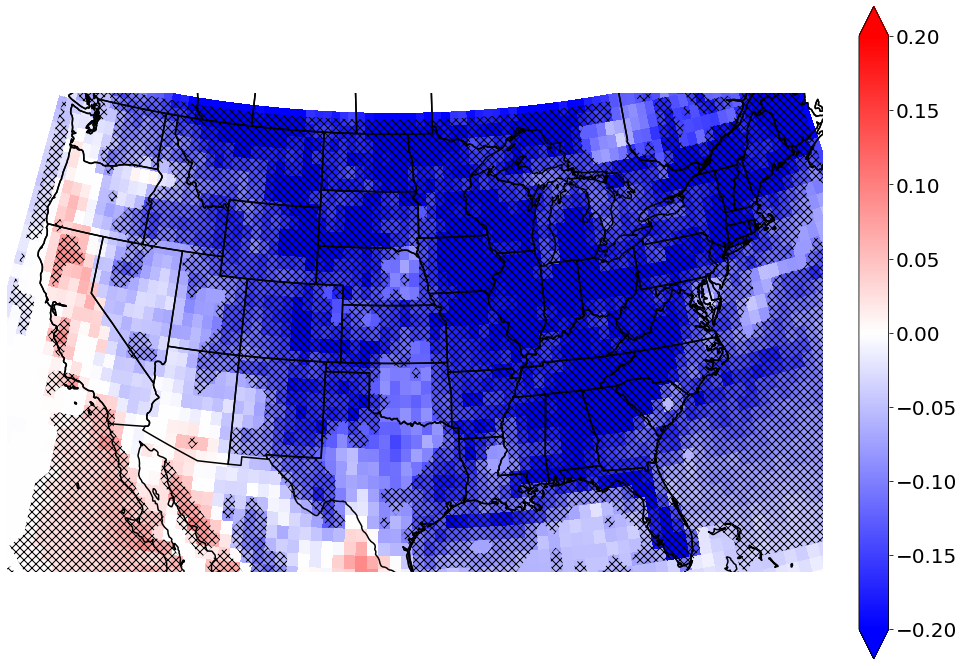

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-125.8593,-64.6874,0.7)
gridlats= np.arange(20,50.1753,0.7)

plot = plt.pcolormesh(gridlons, gridlats, np.flipud(trend_mat), 
                     transform=crs.PlateCarree(), cmap= 'bwr', vmax= 0.2, vmin= -0.2)

lons = (gridlons[:-1] + gridlons[1:])/2
lats = (gridlats[:-1] + gridlats[1:])/2

ax.contourf(lons, lats, np.flipud(trend_pv <= alpha_new), transform=crs.PlateCarree(), colors='none', levels=[.5,1.5],
    hatches=[3*'x',3*'x'])

trend_mat = trend_slope * 10


font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/NOAA20CR_trend_1950_2015.jpeg'
            ,dpi=600)

plt.show()

## 5: Seasonality of volatility

In [45]:
julian_day = np.empty([43, 87])
julian_day[:] = np.nan

for lat in range(d.shape[0]):
    for lon in range(d.shape[1]):
        
        v = pd.DataFrame(columns= ['date', 'day', 'month', 'year', 'volatility'], index= list(range(len(date))))
        v['date'] = date
        v['day'] = v.date.dt.day
        v['month'] = v.date.dt.month
        v['year'] = v.date.dt.year
        
        x = tmax[lat,lon,:]
        v['volatility'][1:] = abs(x[1:] - x[:-1])
        v['volatility'] = v['volatility'].astype(float)
        v= v.drop(v[(v['day'] == 31) & (v['month']== 12)].index)
        v= v.drop(v[(v['day'] == 1) & (v['month']== 1)].index)
        
        climatology = v.groupby(by= ['month', 'day'], dropna=False).mean()
        
        julian_day[lat,lon] = np.argmax(climatology['volatility'])

In [46]:
dummy = np.nanmean(volatility_95p, axis= 2)

for lat in range(dummy.shape[0]):
    for lon in range(dummy.shape[1]):
        if np.isnan(dummy[lat,lon]):
            julian_day[lat,lon] = np.nan

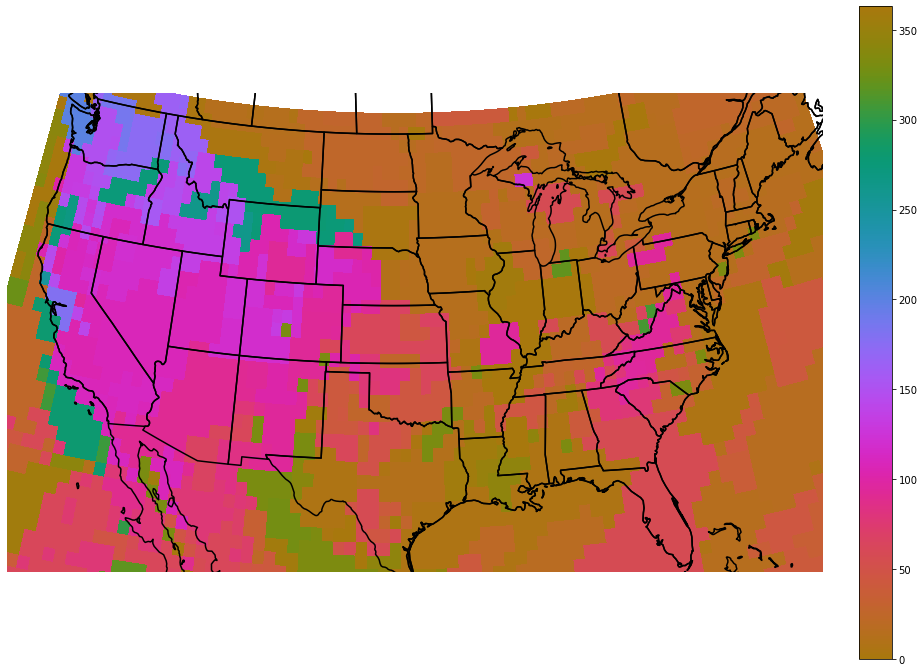

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-125.8593,-64.6874,0.7)
gridlats= np.arange(20,50.1753,0.7)
plot = plt.pcolormesh(gridlons, gridlats, np.flipud(julian_day), transform=crs.PlateCarree(), 
                 cmap= cmocean.cm.phase)

font = {'family':'serif','weight':'bold', 'size': 16}
cbar= plt.colorbar(plot,fraction=0.046, pad=0.04)
#plt.title('1950-2014 NOAA20CR_Seasonality of Volatility Tmax', fontdict= font)

plt.savefig('.../Results/Figures/NOAA20CR_seasonality_1950_2015.jpeg'
            ,dpi=600)

plt.show()

## 6: Direction of Volatility

In [48]:
date = pd.date_range(start='01/01/1950', end='12/31/2014')

volatility_dir = np.empty([43, 87, 65])
volatility_dir[:] = np.nan

for lat in range(d.shape[0]):
    for lon in range(d.shape[1]):
        
        v = pd.DataFrame(columns= ['date', 'day', 'month', 'year', 'volatility'], index= list(range(len(date))))
        v['date'] = date
        v['day'] = v.date.dt.day
        v['month'] = v.date.dt.month
        v['year'] = v.date.dt.year
        
        x = tmax[lat,lon,:]
        v['volatility'][1:] = x[1:] - x[:-1]
        v['volatility'] = v['volatility'].astype(float)
        v= v.drop(v[(v['day'] == 31) & (v['month']== 12)].index)
        v= v.drop(v[(v['day'] == 1) & (v['month']== 1)].index)
        
        for y in range(len(years)):
            dummy= v[v['year']== years[y]]
            xx= dummy['volatility']
            xx= xx[abs(xx) > np.nanpercentile(abs(xx), 95)]
            volatility_dir[lat,lon,y] = np.sum(xx >0) / len(xx)

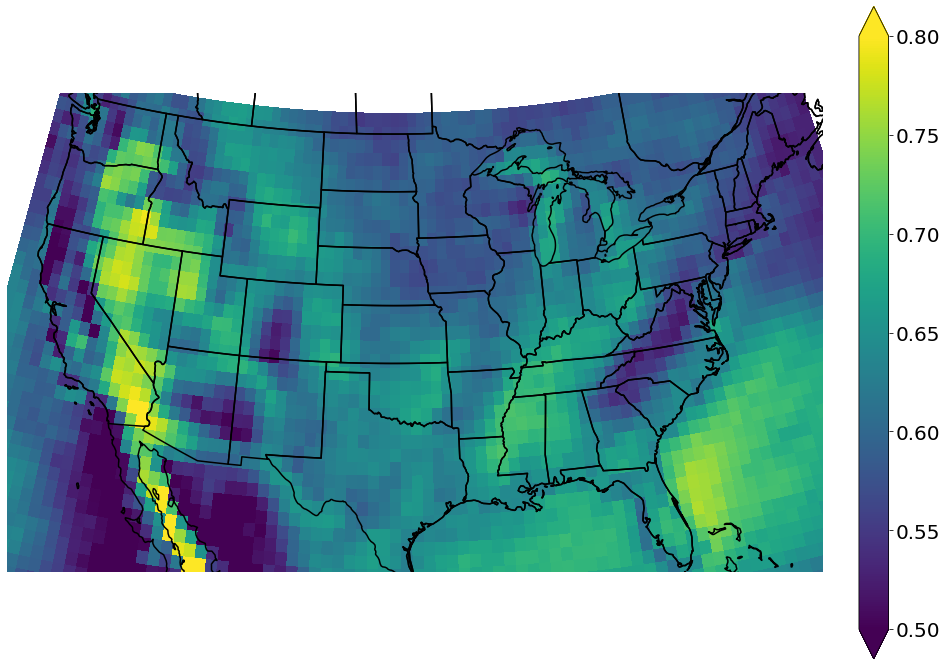

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle='-', edgecolor= 'black', linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle='-', edgecolor= 'black', linewidth=1.5)
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

gridlons= np.arange(-125.8593,-64.6874,0.7)
gridlats= np.arange(20,50.1753,0.7)

data = np.nanmean(volatility_dir, axis=2)
data = 1 - data

plot = plt.pcolormesh(gridlons, gridlats, np.flipud(data), transform=crs.PlateCarree(), 
                      cmap='viridis', vmin= 0.5, vmax= 0.8)

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('.../Results/Figures/NOAA20CR_directionality_1950_2015.jpeg'
            ,dpi=600)

plt.show()

## 7: Save results

In [50]:
# save results

np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/NOAA20CR_volatility_95p', 
           volatility_95p)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/NOAA20CR_julian_day',
          julian_day)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/NOAA20CR_volatility_dir',
          volatility_dir)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/NOAA20CR_trend_slope',
          trend_slope)
np.save('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/NOAA20CR_trend_p-value',
          trend_pv)